In [1]:
from profiler.core import *

/root/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
# pf.session.load_data(name='hospital_clean_sample_join_500', src=FILE, fpath='data/hospital_clean_sample_join_new_200.csv', check_param=True)
pf.session.load_data(name='customer', src=FILE, fpath='data/customer.csv', check_param=True)

INFO:profiler.utility:[1.3987956047058105] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'none', '?', 'unknown', 'nan', 'NaN', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "c_custkey": "text",
    "c_name": "text",
    "c_address": "numeric",
    "c_nationkey": "text",
    "c_phone": "numeric",
    "c_acctbal": "categorical",
    "c_mktsegment": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'c_custkey': ['equal'], 'c_name': ['equal'], 'c_address': ['equal'], 'c_nationkey': ['equal'], 'c_phone': ['equal'], 'c_acctbal': ['equal'], 'c_mktsegment': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[3.

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample', 'HospitalType', 'HospitalOwner','Condition'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC, TEXT, TEXT, TEXT],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients', None, None, None])

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [4]:
pf.session.load_training_data(multiplier = None, difference=True)

INFO:profiler.utility:[14.670958518981934] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 1 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 1, and the bound is 0.00003333
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
INFO:profiler.data.transformer:Number of training samples: 1050000
INFO:profiler.data.transformer:Computing Differences
/root/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[21.675612449645996] Create Training Data execution time: 7.0046539306640625



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [5]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[26.199251174926758] Learn Structure start

INFO:profiler.learner:use threshold 0.0254
INFO:profiler.utility:[26.335502862930298] Learn Structure execution time: 0.13625168800354004



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [6]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[29.800638914108276] Get Dependencies start

INFO:profiler.utility:[29.912676334381104] Get Dependencies execution time: 0.11203742027282715



c_address -> c_phone (0.2010879051690762)
c_address,c_phone -> c_acctbal (0.21735996562020662)
{'c_nationkey': array([], dtype=object), 'c_address': array([], dtype=object), 'c_phone': array(['c_address'], dtype=object), 'c_acctbal': array(['c_address', 'c_phone'], dtype=object)}


In [7]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [8]:
gt = read_fds()

In [9]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    if child in gt:
        for parent in gt[child]:
            if set(parent).issubset(found):
                tp += 1
                match = True
                break
    if not match:
        print("{} -> {} is not valid".format(found, child))

print("Precision: %.4f"%(float(tp) / count))

['c_address'] -> c_phone is not valid
['c_address' 'c_phone'] -> c_acctbal is not valid
Precision: 0.0000


## 5. Visualization

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


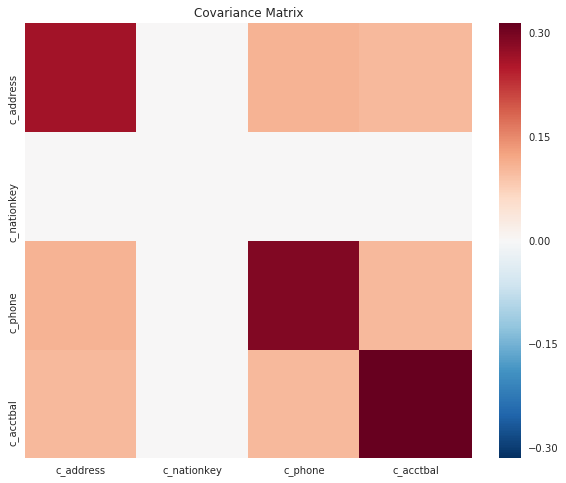

In [10]:
pf.session.visualize_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


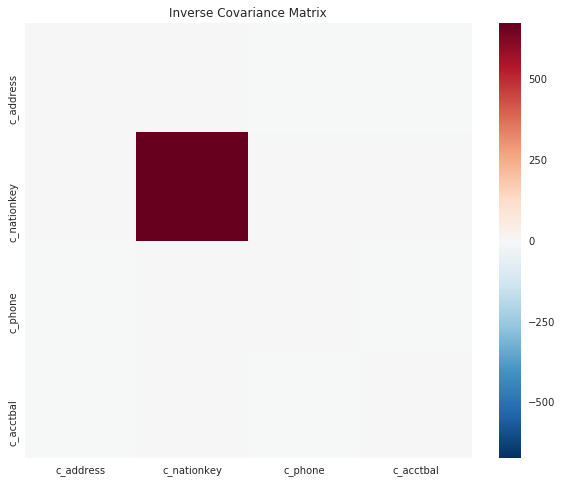

In [11]:
pf.session.visualize_inverse_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


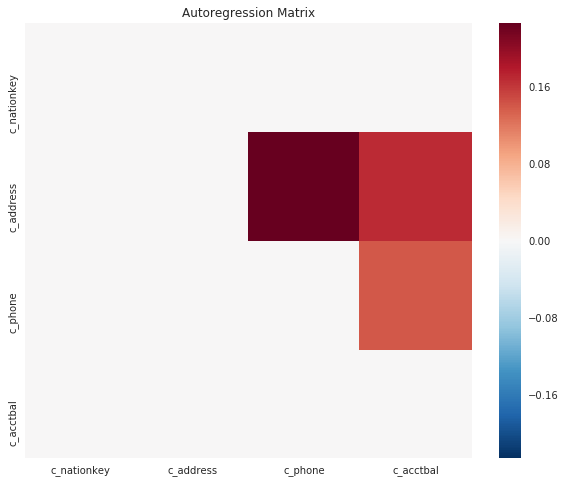

In [12]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.039711,start: Load Data,0.000000
1,0.146057,end: Load Data,0.106346
2,0.255845,start: Create Training Data,0.000000
3,0.886822,end: Create Training Data,0.630977
4,0.898539,start: Learn Structure,0.000000
5,3.156699,end: Learn Structure,2.258161
6,3.167866,start: Get Dependencies,0.000000
7,3.327627,end: Get Dependencies,0.159760
8,3.327627,total_execution_time,3.155245
